<a href="https://colab.research.google.com/github/Jahan08/Advanced-AI-algorithm-practice-hERG-data/blob/main/Building_a_simple_QSAR_model_using_a_feed_forward_neural_network_in_PyTorch_hERG_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 55.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [4]:
data = pd.read_csv("/content/hERG_bioactivity_pIC50.csv")
data.head(1)

,assay_chembl_id,assay_description,canonical_smiles,Source,Name,hERG_uM,Activity,pIC50
0,CHEMBL841079,Inhibition of hERG currents Kv11.1,O=C1NCCN1CCN1CCC(c2cn(-c3ccc(F)cc3)c3ccc(Cl)cc...,J Med Chem,CHEMBL12713,0.014,1,7.853872


In [6]:
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem
PandasTools.AddMoleculeColumnToFrame(data,'canonical_smiles','Molecule')
data[["canonical_smiles","Molecule"]].head(1)

,canonical_smiles,Molecule
0,O=C1NCCN1CCN1CCC(c2cn(-c3ccc(F)cc3)c3ccc(Cl)cc...,<rdkit.Chem.rdchem.Mol object at 0x7cc3a327fb50>


Some of the SMILES may not be sanitizable by RDKit. I’ll check if some of the SMILES could not be converted by looking for None values in the Molecule column

In [7]:
data.Molecule.isna().sum()

0

All the SMILES appear to be converted for this dataset. Good.

# **Vectorizing the molecules**

The Morgan fingerprint is a standard for fingerprinting molecules, but others can be tried as well. Calculating the fingerprints with RDKit allows us to convert the molecules into vectors of numbers that can be used for modelling. It’s fast to compute with a little helper function and as an example I’ll convert the fingerprint of molecule number 1 into a little image.

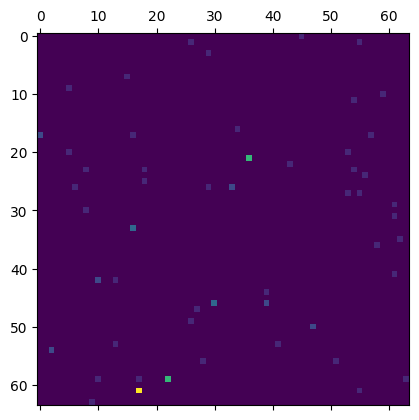

In [16]:
def mol2fp(mol):
    fp = AllChem.GetHashedMorganFingerprint(mol, 2, nBits=4096)
    ar = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, ar)
    return ar

fp =mol2fp(Chem.MolFromSmiles(data.loc[1,"canonical_smiles"]))
plt.matshow(fp.reshape((64,-1)))

Using the apply function of the pandas dataframe makes it easy to add a new column with the fingerprint vectors.

In [17]:
data["FPs"] = data.Molecule.apply(mol2fp)


#**Splitting and converting data to PyTorch tensors**

PyTorch need to train on pytorch tensors, which are similar to Numpy arrays, but with some extra features such a the ability to be transferred to the GPU memory. But first we’ll devide the dataset into train, validation and test using scikit learn.

In [18]:
X = np.stack(data.FPs.values)
print(X.shape)

(2968, 4096)


In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [20]:
y = data.pIC50.values.reshape((-1,1))
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.10, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train,  test_size=0.05, random_state=42)
#Normalizing output using standard scaling
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)
y_validation = scaler.transform(y_validation)

I’ll remove some the bits with the lowest variance. They can be almost always on, or very seldom used. The VarienceThreshold class from scikit-learn is handy for just that. Just as for the normalization, we’ll compute the variance using the train set only, and use it to remove the same features from all the data sets.

In [21]:
# We'll remove low variance features
from sklearn.feature_selection import VarianceThreshold
feature_select = VarianceThreshold(threshold=0.05)
X_train = feature_select.fit_transform(X_train)
X_validation = feature_select.transform(X_validation)
X_test = feature_select.transform(X_test)
X_train.shape

(2537, 258)

Seems like most of the bits were seldom used. The threshold is a hyper-parameter of the entire pipeline for the model, and could be tuned. We’l move the datasets to the GPU and convert them to pytorch tensors.

In [22]:
# Let's get those arrays transfered to the GPU memory as tensors
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# If you don't have a GPU, buy a graphics card. I have for a long time used a 1060 GTX, which is not that expensive anymore.
X_train = torch.tensor(X_train, device=device).float()
X_test = torch.tensor(X_test, device=device).float()
X_validation = torch.tensor(X_validation, device=device).float()
y_train = torch.tensor(y_train, device=device).float()
y_test = torch.tensor(y_test, device=device).float()
y_validation = torch.tensor(y_validation, device=device).float()
X_train

cuda:0


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]], device='cuda:0')

In [23]:
X_train.shape

torch.Size([2537, 258])

Pytorch work with datasets and dataloaders to feed the minibatches to the model during training, so we convert the data. It’s easy to create a dataset from the already created tensors. The batch size is set to 256 and the trainloader will shuffle the data when an epoch has been used.

In [24]:
from torch.utils.data import TensorDataset
train_dataset = TensorDataset(X_train, y_train)
validation_dataset = TensorDataset(X_validation, y_validation)

In [25]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=256,
                                          shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,
                                          batch_size=256,
                                          shuffle=False)

Good, with the training data ready it’s time for the fun part: Defining the network. In PyTorch this can be done by subclassing the nn.Module. The __init__ function will set up all the layers needed in the network, and the forward method will define how they are used in a syntax very similar to the Keras functional api: tensor = layer()(tensor). There’s no activation function for the final output, as this is a regression model, the linear activation is just fine.

In [26]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate, out_size):
        super(Net, self).__init__()
        # Three layers and a output layer
        self.fc1 = nn.Linear(input_size, hidden_size)  # 1st Full-Connected Layer
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc_out = nn.Linear(hidden_size, out_size) # Output layer
        #Layer normalization for faster training
        self.ln1 = nn.LayerNorm(hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)
        self.ln3 = nn.LayerNorm(hidden_size)
        #LeakyReLU will be used as the activation function
        self.activation = nn.LeakyReLU()
        #Dropout for regularization
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):# Forward pass: stacking each layer together
        # Fully connected =&amp;gt; Layer Norm =&amp;gt; LeakyReLU =&amp;gt; Dropout times 3
        out = self.fc1(x)
        out = self.ln1(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.ln2(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = self.fc3(out)
        out = self.ln3(out)
        out = self.activation(out)
        out = self.dropout(out)
        #Final output layer
        out = self.fc_out(out)
        return out

In [27]:
#Defining the hyperparameters
input_size = X_train.size()[-1]     # The input size should fit our fingerprint size
hidden_size = 1024   # The size of the hidden layer
dropout_rate = 0.80    # The dropout rate
output_size = 1        # This is just a single task, so this will be one
learning_rate = 0.001  # The learning rate for the optimizer
model = Net(input_size, hidden_size, dropout_rate, output_size)

The model can be moved to the GPU with the .cuda() method inherited from the nn.Module class. I’ve yet to look up how the module discovers the layers that were set as properties.

In [28]:
model.cuda()

Net(
  (fc1): Linear(in_features=258, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc_out): Linear(in_features=1024, out_features=1, bias=True)
  (ln1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (ln2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (ln3): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (activation): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.8, inplace=False)
)

For a loss function I’ll use the mean squared error. Adam is chosen for the optimizer.

In [29]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Training is a bit more handheld than in Keras. This gives flexibility to train the network layers in different ways, but here we just train it with all the data. For each epoch, the running_loss is zeroed, and the minibatches fetched from the train data in the DataLoader. We start each mini-batch loop by zeroing the gradients. All forward computations done from this point on, will be recorded and used to calculate the backward pass needed for optimzing the weights of the network. At the end of each epoch, some statistics is printed so that it’s possible to follow the training.

In [30]:
model.train() #Ensure the network is in "train" mode with dropouts active
epochs = 200
for e in range(epochs):
    running_loss = 0
    for fps, labels in train_loader:
        # Training pass
        optimizer.zero_grad() # Initialize the gradients, which will be recorded during the forward pa

        output = model(fps) #Forward pass of the mini-batch
        loss = criterion(output, labels) #Computing the loss
        loss.backward() # calculate the backward pass
        optimizer.step() # Optimize the weights

        running_loss += loss.item()
    else:
        if e%10 == 0:
            validation_loss = torch.mean(( y_validation - model(X_validation) )**2).item()
            print("Epoch: %3i Training loss: %0.2F Validation loss: %0.2F"%(e,(running_loss/len(train_loader)), validation_loss))


Epoch:   0 Training loss: 1.47 Validation loss: 0.92
Epoch:  10 Training loss: 0.53 Validation loss: 0.54
Epoch:  20 Training loss: 0.39 Validation loss: 0.50
Epoch:  30 Training loss: 0.29 Validation loss: 0.39
Epoch:  40 Training loss: 0.26 Validation loss: 0.46
Epoch:  50 Training loss: 0.23 Validation loss: 0.41
Epoch:  60 Training loss: 0.20 Validation loss: 0.36
Epoch:  70 Training loss: 0.19 Validation loss: 0.35
Epoch:  80 Training loss: 0.18 Validation loss: 0.36
Epoch:  90 Training loss: 0.17 Validation loss: 0.38
Epoch: 100 Training loss: 0.16 Validation loss: 0.43
Epoch: 110 Training loss: 0.16 Validation loss: 0.36
Epoch: 120 Training loss: 0.13 Validation loss: 0.33
Epoch: 130 Training loss: 0.14 Validation loss: 0.44
Epoch: 140 Training loss: 0.13 Validation loss: 0.36
Epoch: 150 Training loss: 0.13 Validation loss: 0.39
Epoch: 160 Training loss: 0.12 Validation loss: 0.34
Epoch: 170 Training loss: 0.12 Validation loss: 0.38
Epoch: 180 Training loss: 0.12 Validation loss

Before using the model for prediction, it must be set to evalulation mode, where the dropout layers are no longer active. We can calculate the prediction on the training set, validation set and the external test set.

In [31]:
model.eval() #Swith to evaluation mode, where dropout is switched off
y_pred_train = model(X_train)
y_pred_validation = model(X_validation)
y_pred_test = model(X_test)

Calculating the root mean square error can be done using the pytorch operators. The .item() method converts single element tensors to Python scalers for printing.

In [32]:

torch.mean(( y_train - y_pred_train )**2).item()

0.055927395820617676

In [33]:

torch.mean(( y_validation - y_pred_validation )**2).item()

0.3003360629081726

In [34]:

torch.mean(( y_test - y_pred_test )**2).item()

0.34144771099090576

The error on the held out test set is actually lower than the validation set, although both are much worse than the train set. This indicates overfitting, even though the dropout rate was set high at 0.8.
Finally, lets evaluate the model visually. Before that is possible there seem to be a need to transport the tensor to cpu, detach it from gradient before we can can convert it to numpy and flatten it.

In [35]:
def flatten(tensor):
    return tensor.cpu().detach().numpy().flatten()

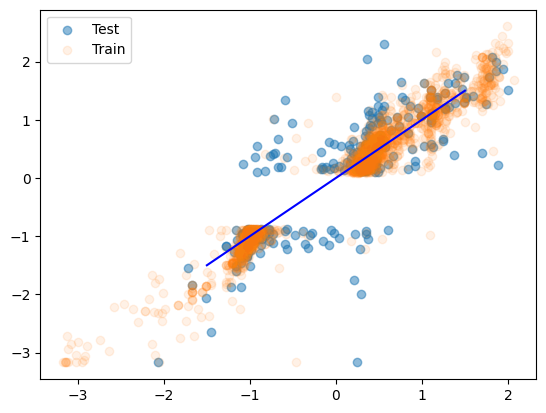

In [36]:
plt.scatter(flatten(y_pred_test), flatten(y_test), alpha=0.5, label="Test")
plt.scatter(flatten(y_pred_train), flatten(y_train), alpha=0.1, label="Train")
plt.legend()
plt.plot([-1.5, 1.5], [-1.5,1.5], c="b")

If we want to predict an arbitrary molecule, we have to remember to use the VarianceThreshold object on the fingerprints and also reverse scale the prediction from the feed forward neural network. The scikit_learn objects are already fit and can be used here.

In [37]:
def predict_smiles(smiles):
    fp =mol2fp(Chem.MolFromSmiles(smiles)).reshape(1,-1)
    fp_filtered = feature_select.transform(fp)
    fp_tensor = torch.tensor(fp_filtered, device=device).float()
    prediction = model(fp_tensor)
    #return prediction.cpu().detach().numpy()
    pIC50 = scaler.inverse_transform(prediction.cpu().detach().numpy())
    return pIC50[0][0]
predict_smiles('Cc1ccc2c(N3CCNCC3)cc(F)cc2n1')

5.1108747

If you read this far, I hope you found it useful. There’s plenty to play around with to improve the model. The hyperparameters could be tuned (such as learning-rate, batch size, size of the hidden layers, activation functions, dropout or regularization with l2 etc.) But experiments with other fingerprints could be also be tried, as well as the feature selection step could be varied.